In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score, accuracy_score, classification_report
import numpy as np
import os
from sklearn.metrics import precision_score, recall_score
import pandas as pd


In [4]:


########################################
# 1. Hyperparameters
########################################
BATCH_SIZE = 8
LR = 0.001
EPOCHS = 10
NUM_CLASSES = 20   # Pascal VOC has 20 classes

########################################
# 2. Transforms
########################################
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize for ResNet50
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

########################################
# 3. Multi-label target encoding
########################################
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
    'tvmonitor'
]

def encode_voc_target(target):
    """Converts VOC annotation to multi-hot vector for 20 classes"""
    objects = target['annotation'].get('object', [])
    if not isinstance(objects, list):
        objects = [objects]  # single object case
    labels = [0] * NUM_CLASSES
    for obj in objects:
        if obj['name'] in VOC_CLASSES:
            idx = VOC_CLASSES.index(obj['name'])
            labels[idx] = 1
    return torch.tensor(labels, dtype=torch.float32)







In [7]:
########################################
# 4. Dataset & Dataloader
########################################
repo_root = "C:/Users/kamed/Desktop/argonne_K/object_detection_with_pascal_voc"
voc_root = os.path.join(repo_root, "VOCdevkit")  # parent of VOC2012

train_dataset = torchvision.datasets.VOCDetection(
    root=repo_root,
    year="2012",
    image_set="train",
    download=False,
    transform=transform,
    target_transform=encode_voc_target
)

val_dataset = torchvision.datasets.VOCDetection(
    root=repo_root,
    year="2012",
    image_set="val",
    download=False,
    transform=transform,
    target_transform=encode_voc_target
)
# Only use first 200 images for CPU testing
train_dataset = torch.utils.data.Subset(train_dataset, list(range(800)))
val_dataset = torch.utils.data.Subset(val_dataset, list(range(200)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

########################################
# 4b. Verify train/val split integrity
########################################

raw_train = torchvision.datasets.VOCDetection(
    root=repo_root,
    year="2012",
    image_set="train",
    download=False,
    transform=None,
    target_transform=None
)

raw_val = torchvision.datasets.VOCDetection(
    root=repo_root,
    year="2012",
    image_set="val",
    download=False,
    transform=None,
    target_transform=None
)
def get_image_ids(dataset):
    ids = []
    for idx in range(len(dataset)):
        # VOCDetection returns (img, target), where target has 'annotation'
        ann = dataset[idx][1]["annotation"]
        img_id = ann["filename"]
        ids.append(img_id)
    return set(ids)

train_ids = get_image_ids(raw_train)
val_ids = get_image_ids(raw_val)

# Intersection should be empty
overlap = train_ids.intersection(val_ids)
if len(overlap) > 0:
    print(f"WARNING ⚠️: {len(overlap)} images appear in both train and val sets!")
else:
    print("✅ No overlap between train and val splits.")

✅ No overlap between train and val splits.


In [5]:
########################################
# 5. Model (ResNet50 with transfer learning)
########################################

ResNetmodel = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in ResNetmodel.parameters():
    param.requires_grad = False # freeze feature extractor

# Replace final layer for 20-class multi-label classification
ResNetmodel.fc = nn.Sequential(
    nn.Linear(ResNetmodel.fc.in_features, NUM_CLASSES),
    nn.Sigmoid()         # since multi-label, we need sigmoid not softmax
)

device = torch.device("cpu")  # force CPU
ResNetmodel = ResNetmodel.to(device)
print("model ready")

model ready


In [10]:
########################################
# 6. Loss & Optimizer
########################################
criterion = nn.BCELoss()  # binary cross entropy for multi-label
optimizer = optim.Adam(ResNetmodel.fc.parameters(), lr=LR)

########################################
# 6. Training Loop
########################################
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, targets in loader:
        images, targets = images.to(device), targets.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

########################################
# 7. Validation / Metrics
########################################
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_curve, auc, multilabel_confusion_matrix

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.float().to(device)
            outputs = model(images)
            y_true.append(targets.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    # Threshold predictions at 0.5 for binary/multi-label classification
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Compute metrics
    roc_auc = roc_auc_score(y_true, y_pred, average="macro")
    f1_micro = f1_score(y_true, y_pred_binary, average="micro")
    f1_macro = f1_score(y_true, y_pred_binary, average="macro")
    acc = accuracy_score(y_true, y_pred_binary)
    cm = multilabel_confusion_matrix(y_true, y_pred_binary)
    report = classification_report(y_true, y_pred_binary, target_names=VOC_CLASSES, zero_division=0)

    return {
        "roc_auc": roc_auc,
        "confusion_matrices": cm,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "accuracy": acc,
        "report": report,
        "y_true": y_true,
        "y_pred": y_pred
    }



In [12]:
########################################
# 8. Run Training
########################################
for epoch in range(EPOCHS):
    loss = train_one_epoch(ResNetmodel, train_loader, optimizer, criterion)
    metrics = evaluate(ResNetmodel, val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f} - Val ROC AUC: {metrics['roc_auc']:.4f} - F1-micro: {metrics['f1_micro']:.4f} - F1-macro: {metrics['f1_macro']:.4f} - Accuracy: {metrics['accuracy']:.4f}")
    print(metrics["report"])

y_true = metrics["y_true"]
y_pred = metrics["y_pred"]


Epoch 1/10 - Loss: 0.2134 - Val ROC AUC: 0.8404 - F1-micro: 0.5747 - F1-macro: 0.0852 - Accuracy: 0.3200
              precision    recall  f1-score   support

   aeroplane       0.00      0.00      0.00         4
     bicycle       0.00      0.00      0.00         8
        bird       0.00      0.00      0.00         8
        boat       0.00      0.00      0.00         7
      bottle       0.00      0.00      0.00        11
         bus       0.00      0.00      0.00         2
         car       0.80      0.21      0.33        19
         cat       1.00      0.06      0.12        16
       chair       1.00      0.24      0.38        17
         cow       0.00      0.00      0.00         2
 diningtable       0.00      0.00      0.00         4
         dog       0.00      0.00      0.00        15
       horse       0.00      0.00      0.00         8
   motorbike       0.00      0.00      0.00         8
      person       0.81      0.94      0.87       123
 pottedplant       0.00      0

[[1.0815474e-03 3.4926459e-04 1.1182174e-02 ... 2.8952077e-02
  8.5003785e-04 3.2884577e-01]
 [1.9199045e-03 3.7828959e-03 8.3842754e-02 ... 1.9271565e-03
  3.3914757e-01 3.2146960e-03]
 [3.4625005e-02 2.5365972e-03 4.5378663e-02 ... 2.8706179e-03
  2.1447666e-02 1.2851133e-03]
 ...
 [1.5542819e-03 2.0426521e-03 6.9221703e-04 ... 2.4710534e-02
  1.9785196e-03 3.4632886e-04]
 [1.2082014e-04 1.5557167e-03 3.5045990e-03 ... 4.2345342e-03
  5.0543540e-04 2.5103050e-03]
 [1.3280710e-03 5.5211508e-01 8.1996983e-03 ... 1.0814433e-03
  8.6810680e-05 1.2769341e-04]]


C:\Users\kamed\AppData\Local\Temp\ipykernel_12656\70783620.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", NUM_CLASSES)


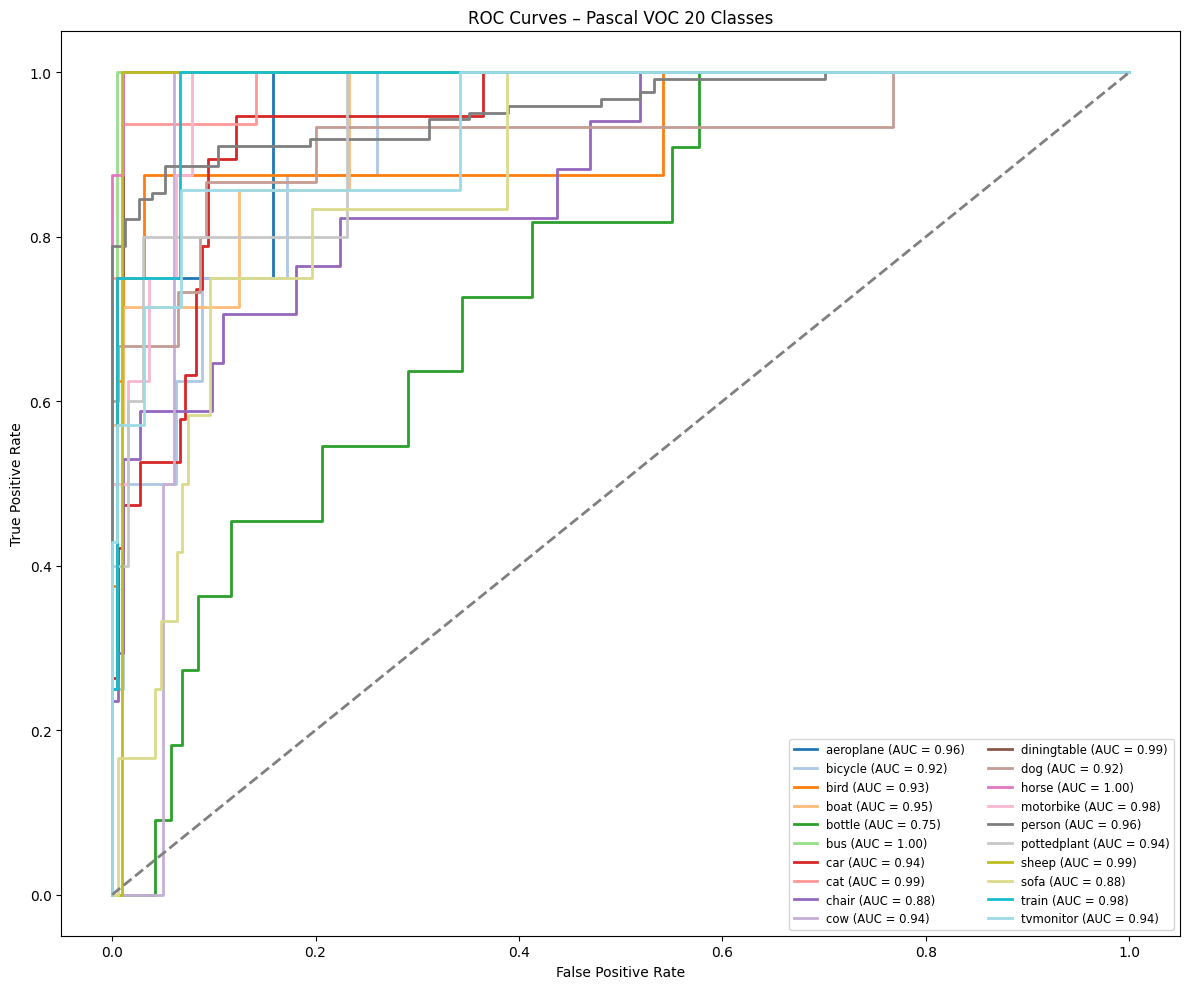

In [13]:
########################################
# 9. Plot ROC Curve for ALL 20 classes
########################################


print(y_pred)
plt.figure(figsize=(12, 10))
colors = plt.cm.get_cmap("tab20", NUM_CLASSES)

for cls_idx, cls_name in enumerate(VOC_CLASSES):
    fpr, tpr, _ = roc_curve(y_true[:, cls_idx], y_pred[:, cls_idx])
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors(cls_idx), lw=2,
             label=f"{cls_name} (AUC = {roc_auc_val:.2f})")

plt.plot([0, 1], [0, 1], "--", color="gray", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Pascal VOC 20 Classes")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.tight_layout()

# Save figure in results/classification_results
classification_results_dir = os.path.join(repo_root, "results", "ResNet_classification_results")
os.makedirs(classification_results_dir, exist_ok=True)

plt.savefig(
    os.path.join(classification_results_dir, "resnet_val_roc_curves.png"),
    bbox_inches="tight"
)
plt.show()

In [ ]:
########################################
# 10. Precision & Recall per class
########################################


# Binary predictions at 0.5 threshold
y_pred_binary = (y_pred > 0.5).astype(int)

# Per-class precision, recall, F1
precision_per_class = precision_score(y_true, y_pred_binary, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred_binary, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred_binary, average=None, zero_division=0)

# Build DataFrame
df_cls_metrics = pd.DataFrame({
    "class": VOC_CLASSES,
    "Precision": precision_per_class,
    "Recall": recall_per_class,
    "F1": f1_per_class
})

# Add macro/micro averages
df_cls_metrics.loc[len(df_cls_metrics)] = [
    "Macro Avg",
    precision_score(y_true, y_pred_binary, average="macro", zero_division=0),
    recall_score(y_true, y_pred_binary, average="macro", zero_division=0),
    f1_score(y_true, y_pred_binary, average="macro", zero_division=0)
]
df_cls_metrics.loc[len(df_cls_metrics)] = [
    "Micro Avg",
    precision_score(y_true, y_pred_binary, average="micro", zero_division=0),
    recall_score(y_true, y_pred_binary, average="micro", zero_division=0),
    f1_score(y_true, y_pred_binary, average="micro", zero_division=0)
]

print("\nPer-class Precision/Recall/F1:\n", df_cls_metrics)

# Save to CSV
#df_cls_metrics.to_csv(os.path.join(repo_root, "resnet_val_precision_recall_f1.csv"), index=False)

df_cls_metrics.to_csv(
    os.path.join(classification_results_dir, "resnet_val_precision_recall_f1.csv"),
    index=False
)
########################################
# 11. Bar charts for Precision, Recall & F1
########################################
import matplotlib.pyplot as plt

# Precision bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_cls_metrics["class"][:-2], df_cls_metrics["Precision"][:-2])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Precision")
plt.title("ResNet Per-Class Precision (Pascal VOC)")
plt.tight_layout()
plt.savefig(os.path.join(classification_results_dir, "resnet_perclass_precision.png"), bbox_inches="tight")
plt.close()

# Recall bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_cls_metrics["class"][:-2], df_cls_metrics["Recall"][:-2])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Recall")
plt.title("ResNet Per-Class Recall (Pascal VOC)")
plt.tight_layout()
plt.savefig(os.path.join(classification_results_dir, "resnet_perclass_recall.png"), bbox_inches="tight")
plt.close()

# F1 bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_cls_metrics["class"][:-2], df_cls_metrics["F1"][:-2])
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.title("ResNet Per-Class F1 (Pascal VOC)")
plt.tight_layout()
plt.savefig(os.path.join(classification_results_dir, "resnet_perclass_f1.png"), bbox_inches="tight")
plt.close()

print("Saved per-class Precision, Recall, and F1 charts for ResNet model.")




NameError: name 'y_pred' is not defined

In [10]:

# --------------------------
# Combined Precision, Recall, F1 bar chart for ResNet (from CSV)
# --------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Paths
repo_root = "C:/Users/kamed/Desktop/argonne_K/object_detection_with_pascal_voc"
classification_results_dir = os.path.join(repo_root, "results", "ResNet_classification_results")
resnet_csv = os.path.join(classification_results_dir, "resnet_val_precision_recall_f1.csv")

# Read CSV
df_resnet = pd.read_csv(resnet_csv)

# Exclude Macro/Micro Avg rows (last 2)
df_resnet_classes = df_resnet.iloc[:-2].reset_index(drop=True)

# Plot
x = np.arange(len(df_resnet_classes["class"]))  # positions for classes
width = 0.25  # bar width

plt.figure(figsize=(14, 7))

# Precision bars (blue)
plt.bar(x - width, df_resnet_classes["Precision"], width, label="Precision")

# Recall bars (orange)
plt.bar(x, df_resnet_classes["Recall"], width, label="Recall")

# F1 bars (green)
plt.bar(x + width, df_resnet_classes["F1"], width, label="F1")

plt.xticks(x, df_resnet_classes["class"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("ResNet Per-Class Precision, Recall, and F1 (Pascal VOC)")
plt.legend()
plt.tight_layout()

# Save into classification_results folder
plt.savefig(os.path.join(classification_results_dir, "resnet_perclass_prf_combined.png"), bbox_inches="tight")
plt.close()

print("Saved combined Precision/Recall/F1 bar chart for ResNet results.")


Saved combined Precision/Recall/F1 bar chart for ResNet results.
